In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder

from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


## Import Dataset

In [2]:
df = pd.read_csv('C:/Users/Gerardo/Documents/Projects/ds4a/datasets/current_final_datset.csv')

cols_to_scale = ['Community_Spending','Unexpected_Housing_Spending','Govt_Direct_Expenditure',
                 'MedianIncome']#,'Number_Interest_Groups','Property_Rights']
cols_to_onehot = ['No_Discrimination_Laws','Private_Fair_Housing',
                  'Public_Fair_Housing','Urban_Fair_Housing',
                  'Banned_Discrimination_Public_Housing',
                  'Banned_Discrimination_Private_Housing',
                  'Legislation_Public_Housing','Rent_Control',
                  'State_Aid_Allowed','Federal_Aid_Allowed',
                  'Prohibit_Rent_Control','Metro']
possible_labels = ['FMR0','Rent50','MedianIncome','FMRRentPercentInc','Rent50PercInc',
                   'Income_Adjusted_FMR0','Income_Adjusted_Rent50','Income_Adjusted_HousingPrices',
                   'Affordability_Price_Point','Housing_Prices_Quarter']

label_col = ['Rent50']

cols_to_think_about = ['State','Year','County','Is_FMR0_Affordable','Is_Rent_Affordable']

y_df = df[possible_labels]
X_df = df[cols_to_scale + cols_to_onehot]

print('number of continuous features: ' + str(len(cols_to_scale)))
print('number of categorical features: ' + str(len(cols_to_onehot)))



number of continuous features: 4
number of categorical features: 12


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
class ExtractColumns(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y = None):
        return self
    
    def transform(self,X):
        return X[self.attribute_names].values

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class TestPolys(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names,degree):
        self.attribute_names = attribute_names
        self.degree =degree
    def fit(self,X,y = None):
        return self
    
    def transform(self,X):
        return PolynomialFeatures(degree = self.degree).fit_transform(X)

In [5]:
def my_train_test_split(X,y,test_size = .2):
    tot_size = len(X)
    test_size = int(tot_size * test_size)
    

    test_indx = random.sample(range(tot_size),test_size)
    train_indx = np.setdiff1d(range(tot_size),test_indx)
   
    try:
        X_train = X.iloc[train_indx,:]
        X_test = X.iloc[test_indx,:]
   
        y_train = y.iloc[train_indx,:]
        y_test = y.iloc[test_indx,:]
    except:
        X_train = X[train_indx,:]
        X_test = X[test_indx,:]
   
        y_train = y[train_indx,:]
        y_test = y[test_indx,:]
        
    
    return X_train,X_test,y_train,y_test

In [6]:
label_pipeline = Pipeline([
    ('get_cols',ExtractColumns(label_col)),
    ('minmaxer',MinMaxScaler())
])

num_pipeline = Pipeline([
    ('get_cols',ExtractColumns(cols_to_scale)),
    ('scaler',StandardScaler())
])
cat_pipeline = Pipeline([
    ('get_cols',ExtractColumns(cols_to_onehot)),
    ('onehot',OneHotEncoder()),
])

my_pipeline = ColumnTransformer([
    ('numerical',num_pipeline,cols_to_scale),
    ('categorical',cat_pipeline,cols_to_onehot)
])

my_pipeline = Pipeline([
    ('column_join',my_pipeline),
    ('poly_fit',PolynomialFeatures(degree = 1))
])




In [7]:
X_train, X_test, y_train, y_test = my_train_test_split(X_df,y_df,test_size = .3) #70% training
X_val, X_test, y_val,y_test = my_train_test_split(X_test,y_test,test_size = .5) #15% validation

y_train = label_pipeline.fit_transform(y_train) #only fit the scaling to the test dataset
X_train = my_pipeline.fit_transform(X_train)

y_test = label_pipeline.transform(y_test) #transform but don't fit the scaling to the test/validation dataset
X_test = my_pipeline.transform(X_test)
y_val = label_pipeline.transform(y_val)
X_val = my_pipeline.transform(X_val)


y_train, y_test, y_val = y_train.flatten(), y_test.flatten(), y_val.flatten()
print(X_train.shape)
print(y_train.shape)


(32763, 29)
(32763,)


In [8]:
def train_model(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    
    score = np.sqrt(mean_squared_error(y_test,pred))
    r2 = r2_score(y_test,pred)
    plt.scatter(pred,y_test)
    plt.plot([0,pred.max()],[0,pred.max()],color ='red');
    plt.title('score: ' + str(round(score,2)) + ' r2: ' + str(round(r2,2)))
    
    return score,model

In [9]:
# for_reg = RandomForestRegressor(n_estimators = 500, max_depth = 8,min_samples_split = 16)
# svr_reg = SVR(kernel='poly',degree=2,C=1E3)
# sgd_reg = SGDRegressor(penalty= 'elasticnet',l1_ratio = .5,random_state= 42,learning_rate = 'constant',eta0 = 1E-7)
# ridge_reg = Ridge(alpha = .9)
# 
# ensemble = VotingRegressor(estimators = [
    # ('random_forest',for_reg),
    #('sgd',sgd_reg),
    # ('ridge',ridge_reg)
# ], verbose = True)
# 
# 
# params = {'l1_ratio':[.001, .01, .1, .3, .5, .8],'eta0':10**np.arange(-5,5,dtype=float),'alpha': 10**np.arange(-3,3,dtype=float)}
# gs_sgd = GridSearchCV(SGDRegressor(penalty = 'elasticnet',random_state = 42, max_iter = 10000),param_grid = params,cv = 3).fit(X_train,y_train)
# y_pred = gs_sgd.best_estimator_.predict(X_test)
# score = r2_score(y_test,y_pred)
# 
# plt.scatter(y_pred,y_test)
# plt.plot([0, y_pred.max()],[0, y_pred.max()],'--r')
# plt.title(str(score))
# 
# print(gs_sgd.best_params_)
# 
#score,_ = train_model(ensemble,X_train,X_test,y_train,y_test)
#print(score)


In [10]:
# formula = 'Rent50 ~ Year + State + County + 
# MedianIncome + Metro + No_Discrimination_Laws + 
# Private_Fair_Housing + Public_Fair_Housing +
# Urban_Fair_Housing + Banned_Discrimination_Public_Housing
# + Legislation_Public_Housing + Rent_Control + 
# State_Aid_Allowed + Prohibit_Rent_Control'

In [ ]:
from statsmodels.formula.api import ols

formula = 'Rent50 ~ Year + State + County + MedianIncome + Metro + No_Discrimination_Laws + Private_Fair_Housing + Public_Fair_Housing + Urban_Fair_Housing + Banned_Discrimination_Public_Housing + Legislation_Public_Housing + Rent_Control + State_Aid_Allowed + Prohibit_Rent_Control'
model = ols(formula,data = df).fit()
model.summary()

In [3]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score

import matplotlib.pyplot as plt
import matplotlib

tmp_df = df.copy()
y  =tmp_df['Income_Adjusted_HousingPrices']
X_cont = tmp_df[['Govt_Direct_Expenditure','Unexpected_Housing_Spending','Community_Spending']]
X_cat = tmp_df[['No_Discrimination_Laws','Private_Fair_Housing','Public_Fair_Housing','Urban_Fair_Housing','Banned_Discrimination_Public_Housing','Legislation_Public_Housing','Rent_Control','State_Aid_Allowed','Prohibit_Rent_Control']]
X_cat = pd.get_dummies(X_cat)
X_cat = X_cat.astype(int)
X = pd.concat([X_cont, X_cat],axis=1)

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = .2)

In [4]:
params = {'max_depth':[2,8,16,32,64,128],'min_samples_split':[2,4,8,16,32,64,128,256,512,1028]}
my_tree = DecisionTreeRegressor()

grid_search = GridSearchCV(my_tree,params,cv = 3,n_jobs = -1,verbose = 4)

grid_search.fit(X_train,y_train)

y_pred = grid_search.best_estimator_.predict(X_test)
print(grid_search.best_params_)
r2_score(y_test,y_pred)



Fitting 3 folds for each of 60 candidates, totalling 180 fits
{'max_depth': 32, 'min_samples_split': 4}


0.6856779871504672

In [14]:
X.columns

Index(['Govt_Direct_Expenditure', 'Unexpected_Housing_Spending',
       'Community_Spending', 'No_Discrimination_Laws', 'Private_Fair_Housing',
       'Public_Fair_Housing', 'Urban_Fair_Housing',
       'Banned_Discrimination_Public_Housing', 'Legislation_Public_Housing',
       'Rent_Control', 'State_Aid_Allowed', 'Prohibit_Rent_Control'],
      dtype='object')

In [5]:
feat_importance = grid_search.best_estimator_.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))

feat importance = [3.92035582e-11 2.35796605e-11 1.35018889e-10 3.92066448e-11
 1.28792134e-13 1.83214083e-14 8.55440579e-13 1.69935497e-12
 4.90686391e-12 7.84438356e-14 3.82542431e-12 4.59987951e-12]


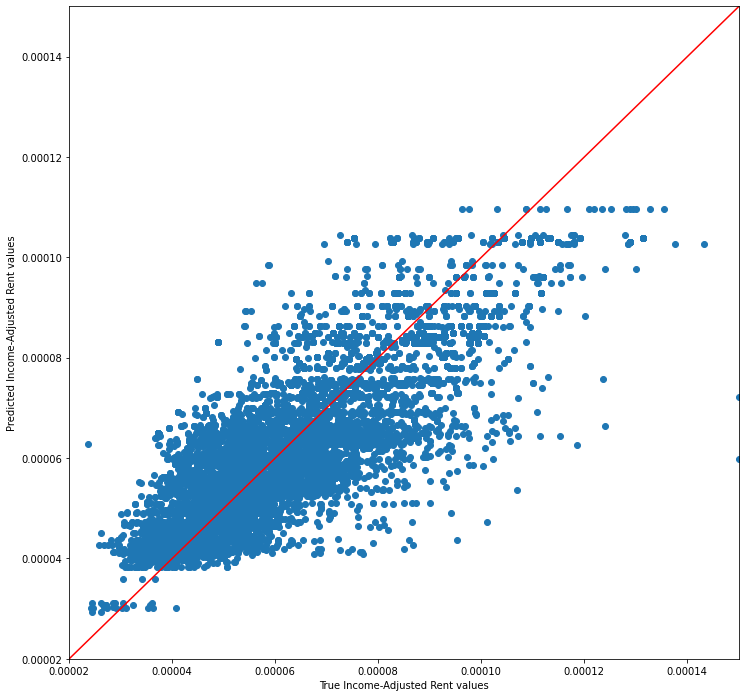

In [7]:
fig,ax = plt.subplots(figsize =(12,12))
ax.scatter(y_test,y_pred)
ax.set_xlim(0.00002 , 0.00015)
ax.set_ylim(0.00002 , 0.00015)
ax.set_xlabel('True Income-Adjusted Rent values')
ax.set_ylabel('Predicted Income-Adjusted Rent values')

ax.plot([0.00002, 0.00015],[0.00002, 0.00015],color = 'red')

font = {'size' : 40}
#matplotlib.rc('font',**font)

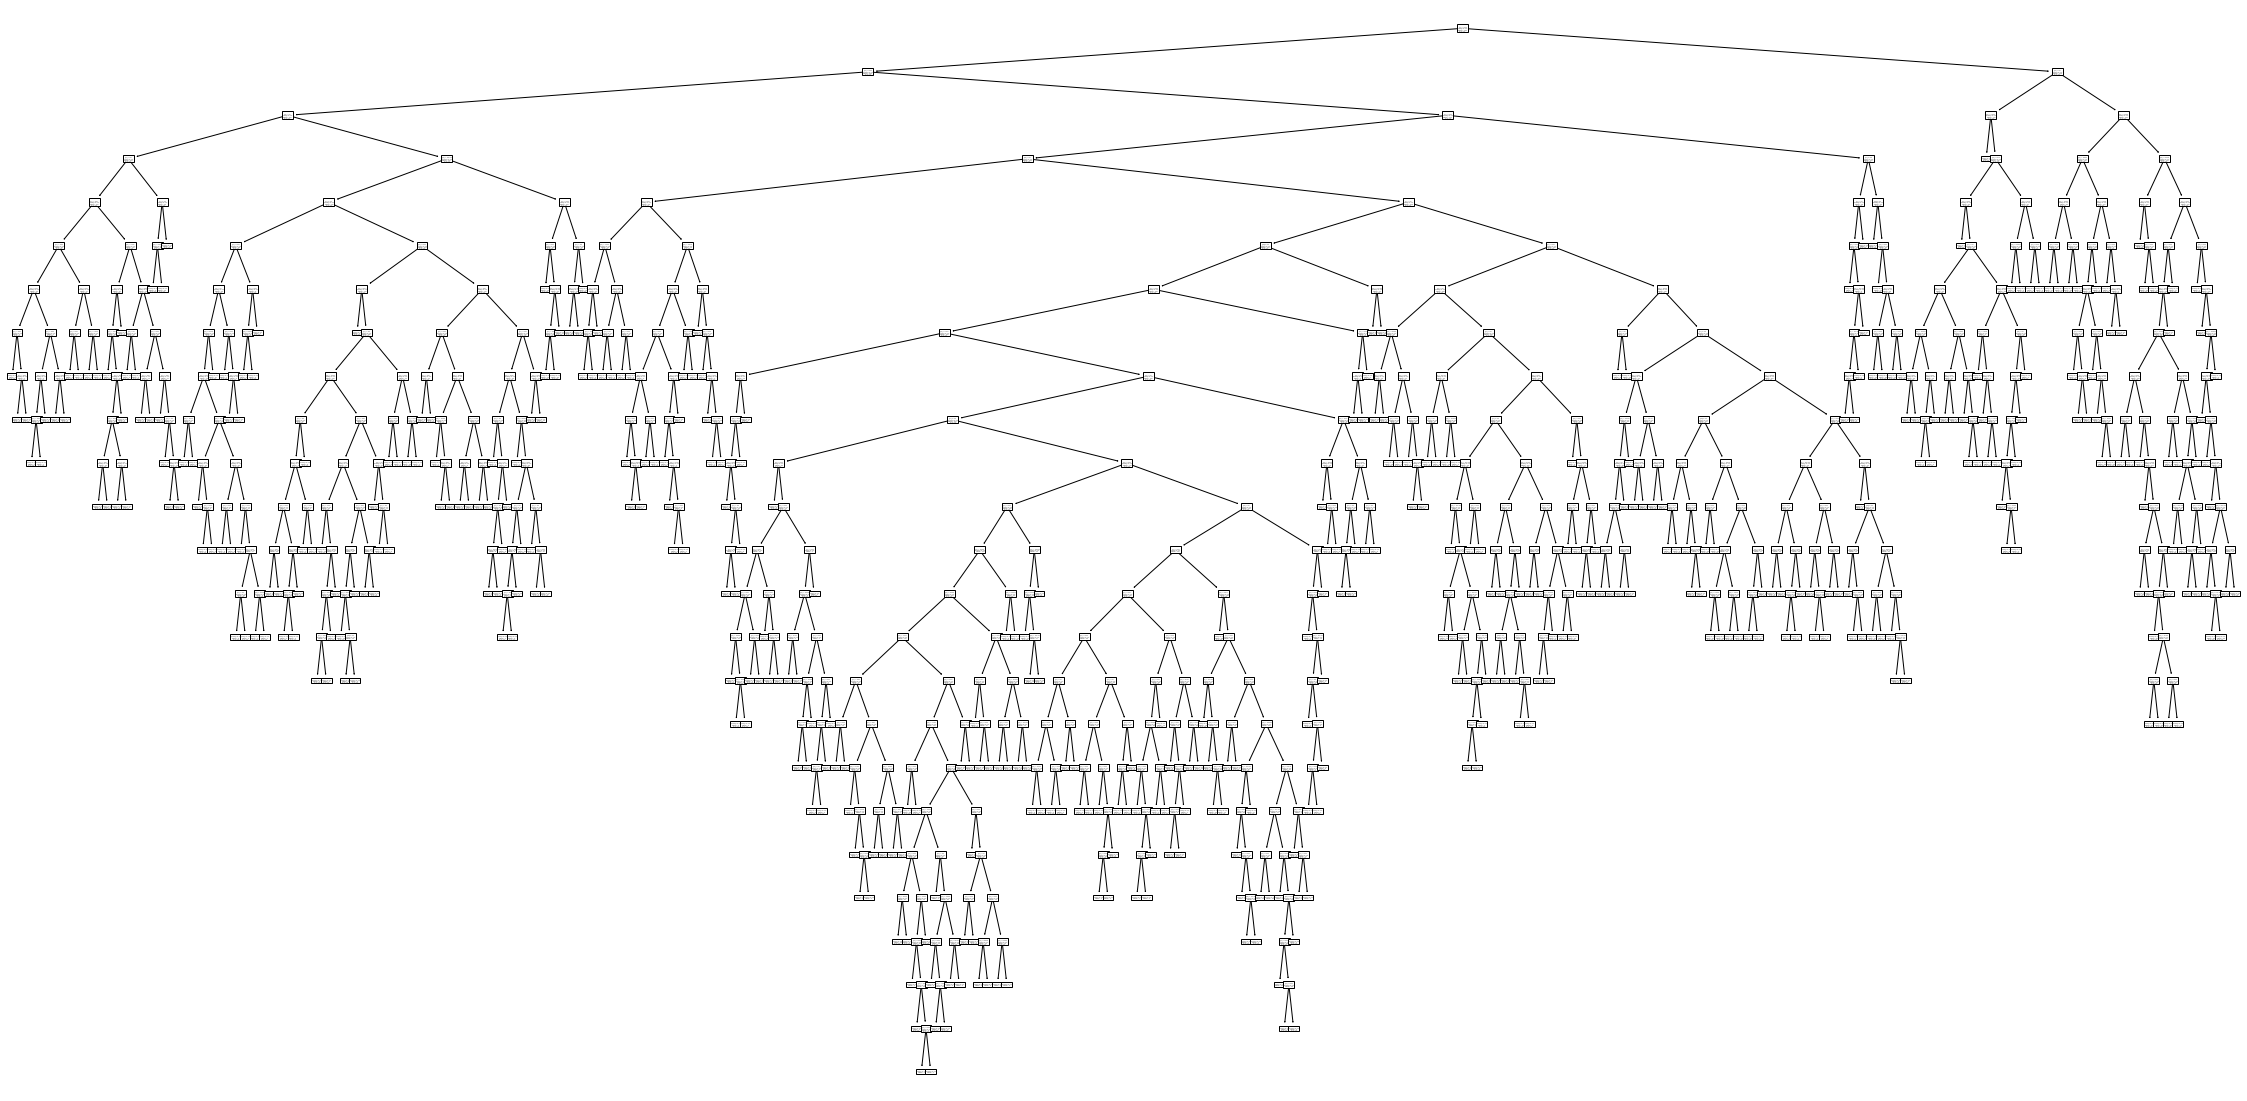

In [202]:
_,ax = plt.subplots(figsize = (40,20))
plot_tree(grid_search.best_estimator_,ax = ax);

In [191]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential(
    [keras.layers.Dense(128,input_shape = [12] ,activation = 'relu'),
    keras.layers.Dense(128,activation = 'relu'),
    keras.layers.Dense(128,activation = 'relu'),
    keras.layers.Dense(1,activation = 'sigmoid')]
)

model.compile(loss = 'mean_squared_error',optimizer = 'Adam')
cb = keras.callbacks.EarlyStopping(patience = 5)
history = model.fit(X_train.values,y_train.values,batch_size = 32, epochs = 50, validation_split = .2)

Epoch 1/50
937/937 [==============================] - 5s 5ms/step - loss: 2.6316e-06 - val_loss: 6.5573e-09
Epoch 2/50
937/937 [==============================] - 4s 4ms/step - loss: 5.4296e-09 - val_loss: 4.7823e-09
Epoch 3/50
937/937 [==============================] - 4s 4ms/step - loss: 4.6570e-09 - val_loss: 4.4746e-09
Epoch 4/50
937/937 [==============================] - 4s 4ms/step - loss: 4.4746e-09 - val_loss: 4.3702e-09
Epoch 5/50
937/937 [==============================] - 4s 4ms/step - loss: 4.4015e-09 - val_loss: 4.3209e-09
Epoch 6/50
937/937 [==============================] - 4s 4ms/step - loss: 4.3641e-09 - val_loss: 4.2936e-09
Epoch 7/50
937/937 [==============================] - 4s 4ms/step - loss: 4.3423e-09 - val_loss: 4.2770e-09
Epoch 8/50
937/937 [==============================] - 4s 5ms/step - loss: 4.3282e-09 - val_loss: 4.2656e-09
Epoch 9/50
937/937 [==============================] - 4s 5ms/step - loss: 4.3185e-09 - val_loss: 4.2573e-09
Epoch 10/50
937/937 [=======

<AxesSubplot:>

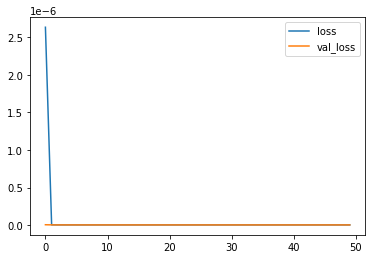

In [192]:
pd.DataFrame(history.history).plot()

In [194]:
y_test

14052    0.000086
10502    0.000046
13838    0.000100
20482    0.000080
34335    0.000043
           ...   
11888    0.000060
42636    0.000073
43950    0.000080
45495    0.000038
35339    0.000070
Name: Income_Adjusted_HousingPrices, Length: 9361, dtype: float64

In [203]:
y_pred2 = model.predict(X_test)
r2_score(y_test,y_pred2)

-10.650404756251998

In [59]:
formula = 'Income_Adjusted_HousingPrices ~ Year + State + No_Discrimination_Laws + Private_Fair_Housing + Public_Fair_Housing + Urban_Fair_Housing + Banned_Discrimination_Public_Housing + Legislation_Public_Housing + Rent_Control + State_Aid_Allowed + Prohibit_Rent_Control + Govt_Direct_Expenditure + Unexpected_Housing_Spending + Community_Spending'
model = ols(formula,data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Income_Adjusted_HousingPrices   R-squared:                       0.664
Model:                                       OLS   Adj. R-squared:                  0.664
Method:                            Least Squares   F-statistic:                     1743.
Date:                           Tue, 15 Mar 2022   Prob (F-statistic):               0.00
Time:                                   00:33:58   Log-Likelihood:             4.6754e+05
No. Observations:                          46804   AIC:                        -9.350e+05
Df Residuals:                              46750   BIC:                        -9.345e+05
Df Model:                                     53                                         
Covariance Type:                       nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        0.0031   3.52e-05     88.617      0.000       0.003       0.003
State[T.AL]                                   5.218e-06   4.26e-07     12.252      0.000    4.38e-06    6.05e-06
State[T.AR]                                   7.753e-07   4.27e-07      1.814      0.070   -6.25e-08    1.61e-06
State[T.AZ]                                   7.079e-07   8.69e-07      0.815      0.415   -9.95e-07    2.41e-06
State[T.CA]                                   4.276e-05    1.7e-06     25.145      0.000    3.94e-05    4.61e-05
State[T.CO]                                  -7.561e-05    8.9e-07    -84.986      0.000   -7.74e-05   -7.39e-05
State[T.CT]                                   -8.78e-05   7.78e-07   -112.905      0.000   -8.93e-05   -8.63e-05
State[T.DE]                                   5.259e-05   1.89e-06     27.810      0.000    4.89e-05    5.63e-05
State[T.FL]                                   4.443e-06   7.91e-07      5.615      0.000    2.89e-06    5.99e-06
State[T.GA]                                   1.084e-06   3.49e-07      3.110      0.002    4.01e-07    1.77e-06
State[T.HI]                                      0.0004   4.38e-06     88.123      0.000       0.000       0.000
State[T.IA]                                      0.0002    2.3e-06     84.528      0.000       0.000       0.000
State[T.ID]                                  -3.717e-06   5.35e-07     -6.942      0.000   -4.77e-06   -2.67e-06
State[T.IL]                                     -0.0001   1.63e-06    -81.333      0.000      -0.000      -0.000
State[T.IN]                                  -2.374e-05   4.19e-07    -56.609      0.000   -2.46e-05   -2.29e-05
State[T.KS]                                      0.0005   5.45e-06     87.903      0.000       0.000       0.000
State[T.KY]                                   8.879e-06   3.42e-07     25.928      0.000    8.21e-06    9.55e-06
State[T.LA]                                  -1.945e-06   5.96e-07     -3.264      0.001   -3.11e-06   -7.77e-07
State[T.MA]                                  -5.187e-05   8.01e-07    -64.753      0.000   -5.34e-05   -5.03e-05
State[T.MD]                                  -3.554e-05   7.27e-07    -48.898      0.000    -3.7e-05   -3.41e-05
State[T.ME]                                   7.772e-05   7.62e-07    102.007      0.000    7.62e-05    7.92e-05
State[T.MI]                                   3.984e-05   6.39e-07     62.322      0.000    3.86e-05    4.11e-05
State[T.MN]                                  -8.086e-05   8.56e-07    -94.426      0.000   -8.25e-05   -7.92e-05
State[T.MO]             